This notebook concerns about pose estimation and augmented reality (AR)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

In [10]:
import camera
import homography

In [3]:
# Read data and detect features

img1 = cv.imread('../../images/pose/bible_front.jpg',0) # Frontal view
img2 = cv.imread('../../images/pose/bible_pose.jpg',0) # Pose we want to estimate

# SIFT
sift = cv.SIFT_create()

kp1,des1 = sift.detectAndCompute(img1,None)
kp2,des2 = sift.detectAndCompute(img2,None)

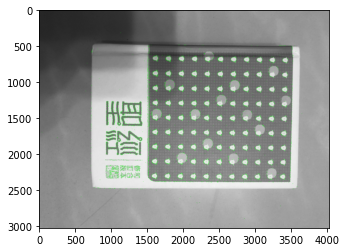

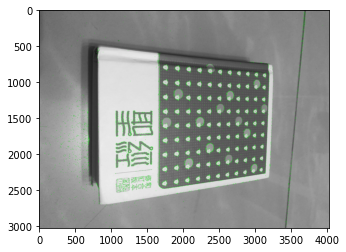

In [4]:
# Illustration of features

img1_kp = cv.drawKeypoints(img1,kp1,None,(0,255,0))
img2_kp = cv.drawKeypoints(img2,kp2,None,(0,255,0))

plt.figure()
plt.gray()
plt.imshow(img1_kp)

plt.figure()
plt.gray()
plt.imshow(img2_kp)

plt.show()

In [5]:
# Match features

MIN_MATCH_COUNT = 10
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

flann = cv.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(des1,des2,k=2)

good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

In [6]:
# Find homography in case we have sufficient matches, else print a message
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    
    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    
    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv.perspectiveTransform(pts,M)
    img2 = cv.polylines(img2,[np.int32(dst)],True,255,3, cv.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

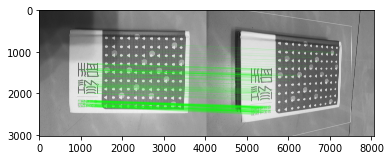

In [7]:
# Plot matches
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                    singlePointColor = None,
                    matchesMask = matchesMask, # draw only inliers
                    flags = 2)
img3 = cv.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
plt.imshow(img3, 'gray')
plt.show()

To show how the pose is estimated, we place a cube on frontal image with base sqaure having vertices equal first four matching keypoints, and see how it changes as we apply the homography.

In [8]:
# Function for generating the cube points in 3D space
def cube_points(c,wid):
    """ Creates a list of points for plotting
    a cube with centre c. (the first 5 points are
    the bottom square, some sides repeated). """
    
    p = []
    
    # Bottom
    p.append([c[0]-wid,c[1]-wid,c[2]-wid])
    p.append([c[0]-wid,c[1]+wid,c[2]-wid])
    p.append([c[0]+wid,c[1]+wid,c[2]-wid])
    p.append([c[0]+wid,c[1]-wid,c[2]-wid])
    p.append([c[0]-wid,c[1]-wid,c[2]-wid]) # Same as first line to close plot
    
    # Top
    p.append([c[0]-wid,c[1]-wid,c[2]+wid])
    p.append([c[0]-wid,c[1]+wid,c[2]+wid])
    p.append([c[0]+wid,c[1]+wid,c[2]+wid])
    p.append([c[0]+wid,c[1]-wid,c[2]+wid])
    p.append([c[0]-wid,c[1]-wid,c[2]+wid]) # Same as first to close plot
    
    # Vertical Sides
    p.append([c[0]-wid,c[1]-wid,c[2]+wid])
    p.append([c[0]-wid,c[1]+wid,c[2]+wid])
    p.append([c[0]-wid,c[1]+wid,c[2]-wid])
    p.append([c[0]+wid,c[1]+wid,c[2]-wid])
    p.append([c[0]+wid,c[1]+wid,c[2]+wid])
    p.append([c[0]+wid,c[1]-wid,c[2]+wid])
    p.append([c[0]+wid,c[1]-wid,c[2]-wid])
    
    return np.array(p).T

In [9]:
# Camera calibration
K = camera.my_calibration((4032,3024))

In [12]:
# 3D points at plane z=0 with sides of length 0.2
box = cube_points([0,0,0.1],0.1)

# Project bottom of the square to img1
cam1 = camera.Camera(np.hstack((K,K@np.array([[0],[0],[-1]]))))
# First five points are the bottom square
box_cam1 = cam1.project(homography.make_homog(box[:,:5]))

In [15]:
# Use M to transfer points to second image
box_trans = homography.normalize(M@box_cam1)

# Compute second camera matrix
cam2 = camera.Camera(M@cam1.P) # P2 = HP1 maps Z=0 to Z=0, i.e. first, second and last columns are correct

# Compute third column by the fact that P2[:,:3] is orthogonal
A = np.linalg.inv(K)@cam2.P[:,:3]
A = np.array([A[:,0],A[:,1],np.cross(A[:,0],A[:,1])])
cam2.P[:,:3] = K@A

In [16]:
# Project with second camera
box_cam2 = cam2.project(homography.make_homog(box))

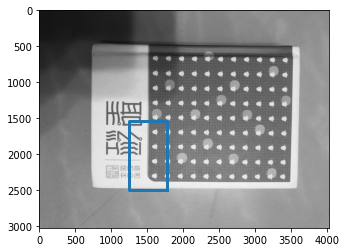

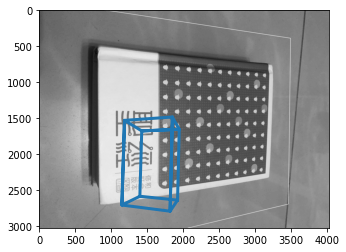

In [19]:
# Visualisation

# img1
plt.figure()
plt.gray()
plt.imshow(img1)
plt.plot(box_cam1[0,:],box_cam1[1,:],linewidth=3)

# 3D cube in img2
plt.figure()
plt.gray()
plt.imshow(img2)
plt.plot(box_cam2[0,:],box_cam2[1,:],linewidth=3)

plt.show()